In [15]:
import os
import sys

PROJECT_ROOT = r"C:\Users\laksh\microstructure-project"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from src.dataset import VoxelHDF5Dataset
from src.models.cnn3d_ae import MicrostructureAE3D

print("PROJECT_ROOT:", PROJECT_ROOT)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


PROJECT_ROOT: C:\Users\laksh\microstructure-project
Using device: cpu


In [16]:
# --- config ---
voxel_root = os.path.join(PROJECT_ROOT, "data", "raw", "ss75fdg5dg-1", "FCC_voxelwise")
ae_weights = os.path.join(PROJECT_ROOT, "data", "processed", "ae_DistanceFrom_epoch20.pt")

# load Voxel dataset (DistanceFrom)
vox_ds = VoxelHDF5Dataset(
    base_dir=voxel_root,
    feature_key="DistanceFrom",
    grid_size=128,
)

# load AE model 
ae_model = MicrostructureAE3D(in_channels=1, latent_dim=4096).to(device)
ae_state = torch.load(ae_weights, map_location=device)
ae_model.load_state_dict(ae_state)
ae_model.eval()


fileid_to_index = {
    1: 0,  
    2: 6,  
    3: 12, 
    4: 18,
    5: 24,
    6: 30,
}

fileid_to_latent = {}

with torch.no_grad():
    for file_id, idx in fileid_to_index.items():
        vol = vox_ds[idx]              # (C,D,H,W), C=1
        vol = vol.unsqueeze(0).to(device)  # (1,C,D,H,W)
        recon, z = ae_model(vol)       # z: (1, latent_dim)
        z = z.squeeze(0).cpu().numpy() # (latent_dim,)
        fileid_to_latent[file_id] = z
        print(f"fileID {file_id}: latent shape {z.shape}")

# sanity
len(fileid_to_latent), list(fileid_to_latent.keys())


Found 36 voxel files for feature 'DistanceFrom'.


C:\Users\laksh\AppData\Local\Temp\ipykernel_13680\2301368918.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae_state = torch.load(ae_weights, map_location=device)


fileID 1: latent shape (4096,)
fileID 2: latent shape (4096,)
fileID 3: latent shape (4096,)
fileID 4: latent shape (4096,)
fileID 5: latent shape (4096,)
fileID 6: latent shape (4096,)


(6, [1, 2, 3, 4, 5, 6])

In [17]:
class FusionGrainDataset(Dataset):
    def __init__(self, csv_paths, fileid_to_latent, min_timesteps=2):
        self.fileid_to_latent = fileid_to_latent
        self.min_timesteps = min_timesteps

        dfs = [pd.read_csv(p) for p in csv_paths]
        df_all = pd.concat(dfs, ignore_index=True)

        # drop useless index col if present
        if "Unnamed: 0" in df_all.columns:
            df_all = df_all.drop(columns=["Unnamed: 0"])

        # sort by fileID + ngr so sequence order is consistent
        df_all = df_all.sort_values(["fileID", "ngr"]).reset_index(drop=True)

        # --- numeric columns only ---
        numeric_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()

        self.target_col = "EqVonMisesStress"
        exclude_cols = ["EqVonMisesStress", "ngr", "fileID"]
        feature_cols = [c for c in numeric_cols if c not in exclude_cols]

        self.feature_cols = feature_cols

        # --- clean NaN / Inf in numeric columns (features + target + keys) ---
        cols_to_check = self.feature_cols + [self.target_col, "ngr", "fileID"]
        df_all[cols_to_check] = df_all[cols_to_check].replace([np.inf, -np.inf], np.nan)
        df_all = df_all.dropna(subset=cols_to_check)

        print("Using feature columns (numeric, cleaned):")
        print(self.feature_cols)

        # group by grain id (ngr)
        self.sequences = []
        for ngr_id, g in df_all.groupby("ngr"):
            if len(g) < min_timesteps:
                continue

            file_id = int(g["fileID"].iloc[0])
            if file_id not in self.fileid_to_latent:
                # skip if we don't have AE latent for this fileID
                continue

            X = g[self.feature_cols].values.astype(np.float32)  # (T,F)
            y = float(g[self.target_col].iloc[-1])              # scalar target
            z = self.fileid_to_latent[file_id].astype(np.float32)  # (latent_dim,)

            self.sequences.append((X, z, y))

        if len(self.sequences) == 0:
            raise RuntimeError("No sequences constructed for FusionGrainDataset.")

        self.feature_dim = len(self.feature_cols)
        self.latent_dim = list(self.fileid_to_latent.values())[0].shape[0]

        print(f"FusionGrainDataset: {len(self.sequences)} sequences, "
              f"feature_dim={self.feature_dim}, latent_dim={self.latent_dim}")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, z, y = self.sequences[idx]   # X: (T,F), z: (Z,), y: scalar
        X = torch.from_numpy(X)         # (T,F)
        z = torch.from_numpy(z)         # (Z,)
        y = torch.tensor([y], dtype=torch.float32)  # (1,)
        return X, z, y


In [18]:
grain_root = os.path.join(
    PROJECT_ROOT, "data", "raw", "ss75fdg5dg-1", "FCC_grainwise", "FCC_grainwise"
)

csv_paths = [
    os.path.join(grain_root, f"micro{i}_all_grainwise.csv")
    for i in range(1, 7)
]

fusion_ds = FusionGrainDataset(csv_paths=csv_paths,
                               fileid_to_latent=fileid_to_latent,
                               min_timesteps=2)

print("Fusion dataset length:", len(fusion_ds))
print("Example shapes:", fusion_ds[0][0].shape, fusion_ds[0][1].shape, fusion_ds[0][2].shape)


Using feature columns (numeric, cleaned):
['Euler_1', 'Euler_2', 'Euler_3', 'AvgMisorientations', 'EquivalentDiameters', 'FeatureVolumes', 'NumCells', 'Neighborhoods', 'NumNeighbors', 'SurfaceFeatures', 'SurfaceAreaVolumeRatio', 'SharedSurfaceAreaList', 'FeatureBoundaryElementFrac', 'Omega3s', 'AspectRatios_0', 'AspectRatios_1', 'F7List', 'F1List', 'F1sptList', 'mPrimeList', 'euler_1', 'euler_2', 'euler_3', 'x', 'y', 'z', 'GBEuc', 'TJEuc', 'QPEuc', 'Taylor', 'KernelAvg', '001_IPF_0', '001_IPF_1', '001_IPF_2', '100_IPF_0', '100_IPF_1', '100_IPF_2', '111_IPF_0', '111_IPF_1', '111_IPF_2', 'Schmid']
FusionGrainDataset: 5182 sequences, feature_dim=41, latent_dim=4096
Fusion dataset length: 5182
Example shapes: torch.Size([35, 41]) torch.Size([4096]) torch.Size([1])


In [19]:
class FusionLSTMModel(nn.Module):
    def __init__(self, feature_dim, latent_dim, hidden_dim=64, num_layers=2, bidirectional=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(
            input_size=feature_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
        )

        lstm_out_dim = hidden_dim * (2 if bidirectional else 1)
        fusion_in_dim = lstm_out_dim + latent_dim

        self.fc = nn.Sequential(
            nn.Linear(fusion_in_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, X_padded, lengths, z_batch):
        
        packed = nn.utils.rnn.pack_padded_sequence(
            X_padded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, (h_n, c_n) = self.lstm(packed)

        if self.bidirectional:
            # concat last forward + last backward
            h_last = torch.cat((h_n[-2], h_n[-1]), dim=-1)  # (B, 2H)
        else:
            h_last = h_n[-1]  # (B,H)

        # concat with latent
        fusion = torch.cat([h_last, z_batch], dim=-1)  # (B, 2H+Z)
        out = self.fc(fusion)                          # (B,1)
        return out


In [20]:
# collate: pad sequences and stack latent + target
def fusion_collate_fn(batch):
    X_list = [b[0] for b in batch]  # list of (T,F)
    z_list = [b[1] for b in batch]  # list of (Z,)
    y_list = [b[2] for b in batch]  # list of (1,)

    lengths = torch.tensor([x.shape[0] for x in X_list], dtype=torch.long)
    X_padded = pad_sequence(X_list, batch_first=True)  # (B,T_max,F)
    z_batch = torch.stack(z_list, dim=0)               # (B,Z)
    y_batch = torch.stack(y_list, dim=0)               # (B,1)

    return X_padded, lengths, z_batch, y_batch

# build loader
fusion_loader = DataLoader(fusion_ds, batch_size=32, shuffle=True, collate_fn=fusion_collate_fn)

# quick sanity batch
Xb, Lb, zb, yb = next(iter(fusion_loader))
print("Batch shapes:", Xb.shape, Lb.shape, zb.shape, yb.shape)

# model
fusion_model = FusionLSTMModel(
    feature_dim=fusion_ds.feature_dim,
    latent_dim=fusion_ds.latent_dim,
    hidden_dim=64,
    num_layers=2,
    bidirectional=True,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-3)


Batch shapes: torch.Size([32, 35, 41]) torch.Size([32]) torch.Size([32, 4096]) torch.Size([32, 1])


In [21]:
from torch.utils.data import random_split, DataLoader

# --- train/val split ---
n_total = len(fusion_ds)
n_train = int(0.8 * n_total)
n_val = n_total - n_train

train_ds, val_ds = random_split(fusion_ds, [n_train, n_val])

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    collate_fn=fusion_collate_fn,
)

val_loader = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=fusion_collate_fn,
)

# check batch shapes
Xb, Lb, zb, yb = next(iter(train_loader))
print("Train batch shapes:", Xb.shape, Lb.shape, zb.shape, yb.shape)


Train batch shapes: torch.Size([32, 35, 41]) torch.Size([32]) torch.Size([32, 4096]) torch.Size([32, 1])


In [22]:
import numpy as np
import torch.nn as nn

fusion_model = FusionLSTMModel(
    feature_dim=fusion_ds.feature_dim,
    latent_dim=fusion_ds.latent_dim,
    hidden_dim=64,
    num_layers=2,
    bidirectional=True,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-3)

n_epochs = 20

for epoch in range(1, n_epochs + 1):
    # ----- TRAIN -----
    fusion_model.train()
    train_loss = 0.0
    train_samples = 0

    for X_batch, lengths, z_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        lengths = lengths.to(device)
        z_batch = z_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds = fusion_model(X_batch, lengths, z_batch)  # (B,1)
        loss = criterion(preds, y_batch)

        if torch.isnan(loss) or torch.isinf(loss):
            print("Skipping batch with NaN/Inf loss")
            continue

        loss.backward()
        optimizer.step()

        bs = y_batch.size(0)
        train_loss += loss.item() * bs
        train_samples += bs

    train_mse = train_loss / train_samples
    train_rmse = float(np.sqrt(train_mse))

    # validation
    fusion_model.eval()
    val_loss = 0.0
    val_samples = 0

    with torch.no_grad():
        for X_batch, lengths, z_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            lengths = lengths.to(device)
            z_batch = z_batch.to(device)
            y_batch = y_batch.to(device)

            preds = fusion_model(X_batch, lengths, z_batch)
            loss = criterion(preds, y_batch)

            if torch.isnan(loss) or torch.isinf(loss):
                print("Skipping val batch with NaN/Inf loss")
                continue

            bs = y_batch.size(0)
            val_loss += loss.item() * bs
            val_samples += bs

    val_mse = val_loss / val_samples
    val_rmse = float(np.sqrt(val_mse))

    print(f"Epoch {epoch:02d} - "
          f"Train MSE: {train_mse:.3f}, RMSE: {train_rmse:.3f} | "
          f"Val MSE: {val_mse:.3f}, RMSE: {val_rmse:.3f}")


Epoch 01 - Train MSE: 1000.303, RMSE: 31.628 | Val MSE: 164.021, RMSE: 12.807
Epoch 02 - Train MSE: 125.888, RMSE: 11.220 | Val MSE: 243.869, RMSE: 15.616
Epoch 03 - Train MSE: 116.187, RMSE: 10.779 | Val MSE: 248.730, RMSE: 15.771
Epoch 04 - Train MSE: 113.540, RMSE: 10.655 | Val MSE: 234.331, RMSE: 15.308
Epoch 05 - Train MSE: 108.333, RMSE: 10.408 | Val MSE: 440.292, RMSE: 20.983
Epoch 06 - Train MSE: 106.644, RMSE: 10.327 | Val MSE: 259.514, RMSE: 16.109
Epoch 07 - Train MSE: 103.826, RMSE: 10.189 | Val MSE: 355.423, RMSE: 18.853
Epoch 08 - Train MSE: 101.055, RMSE: 10.053 | Val MSE: 312.721, RMSE: 17.684
Epoch 09 - Train MSE: 108.846, RMSE: 10.433 | Val MSE: 195.156, RMSE: 13.970
Epoch 10 - Train MSE: 115.371, RMSE: 10.741 | Val MSE: 452.759, RMSE: 21.278
Epoch 11 - Train MSE: 106.662, RMSE: 10.328 | Val MSE: 148.161, RMSE: 12.172
Epoch 12 - Train MSE: 102.427, RMSE: 10.121 | Val MSE: 382.369, RMSE: 19.554
Epoch 13 - Train MSE: 102.793, RMSE: 10.139 | Val MSE: 327.878, RMSE: 18.10

Fusion Val MSE : 134.871
Fusion Val RMSE: 11.613
Fusion Val MAE : 9.770
Fusion Val R^2 : -0.514


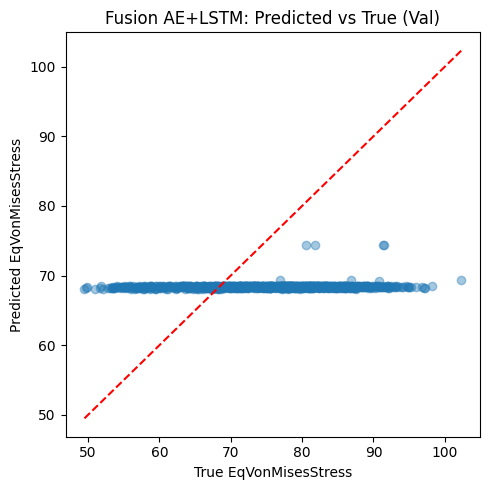

Saved fusion figure to: C:\Users\laksh\microstructure-project\results\figures\fusion_pred_vs_true.png


In [23]:
fusion_model.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X_batch, lengths, z_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        lengths = lengths.to(device)
        z_batch = z_batch.to(device)

        preds = fusion_model(X_batch, lengths, z_batch)  # (B,1)
        preds = preds.cpu().numpy().ravel()
        y_true_list.append(y_batch.numpy().ravel())
        y_pred_list.append(preds)

import numpy as np
import matplotlib.pyplot as plt
import os

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

mse  = np.mean((y_true - y_pred)**2)
rmse = np.sqrt(mse)
mae  = np.mean(np.abs(y_true - y_pred))
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - y_true.mean())**2)
r2   = 1.0 - ss_res / ss_tot

print(f"Fusion Val MSE : {mse:.3f}")
print(f"Fusion Val RMSE: {rmse:.3f}")
print(f"Fusion Val MAE : {mae:.3f}")
print(f"Fusion Val R^2 : {r2:.3f}")

fig_dir = os.path.join(PROJECT_ROOT, "results", "figures")
os.makedirs(fig_dir, exist_ok=True)
fig_path = os.path.join(fig_dir, "fusion_pred_vs_true.png")

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         "r--")
plt.xlabel("True EqVonMisesStress")
plt.ylabel("Predicted EqVonMisesStress")
plt.title("Fusion AE+LSTM: Predicted vs True (Val)")
plt.tight_layout()
plt.savefig(fig_path, dpi=300)
plt.show()

print("Saved fusion figure to:", fig_path)
